# Lab 3-2: Surface Energy Balance at Kettle Ponds - Full Surface Energy Balance
Written by Daniel Hogan - April, 2023.

Modified by Jessica Lundquist - April, 2023.

Modified by Eli Schwat - January 2024.

### Snow Surface Energy Balance Equation 

Consider the snow surface energy balance equation during mid-winter periods when there is no snow melt:

$$ \frac{dU}{dt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - H_L - H_s + G$$

Note that for this lab, we will make the gross assumption that we can approximate the internal energy term like this:

$$\frac{dU}{dt} = c_p^{S} \int^D_0 \frac{\partial T_{s}}{\partial t} dz$$

See the Module 3 page for why this assumption is a poor assumption. Note also that compared to the equations in Module 3, we have taken the specific heat capacity constant outside the time derivative (what is the implication of this choice?). We will explore this in future labs.

Note also that for this lab we will combine the radiation terms into the following term:

$$R_{net} = LW_{in} - LW_{out} + SW_{in} - SW_{out} $$

In Lab 3-1, we already examined the four radiation terms. In this lab, we will estimate the remaining terms. 
We want all measurements to be in units of $W/m^2$. 
The radiation variables are already in these units.
The other variable in the dataset require conversion.

---
### Converting turbulent flux measurements into energy flux units ($W/m^2$)
Without diving too much into the details of the turbulent water vapor (latent heat) flux $H_L$ and sensible heat flux $H_s$, we note that turbulent water vapor flux is measured in units of $g/m^2/s$ and sensible heat flux is measured in units $K/m^2/s$, and are in the dataset as the following variables:

`w_h2o__3m_c` (latent heat flux)

and

`w_tc__3m_c` (sensible heat flux).

---
#### Converting turbulent latent heat flux measurements into energy flux units ($W/m^2$)

To convert `w_h2o__3m_c` (latent heat flux in $g/m^2/s$) to $W/m^2$, we will use the latent heat of sublimation (the sum of the latent heats of fusion and vaporization, $L_{sub} = 2590 J/g$).

$H_l = $ `w_h2o__3m_c` $ * L_{sub}$

and the units work out like this : $\frac{g}{m^2 s} * \frac{J}{g} = \frac{J}{m^2 s} = \frac{W}{m^2}$ (b/c 1 Watt = 1 Joule per second).

---
#### Converting turbulent sensible heat flux measurements into energy flux units ($W/m^2$)

To convert `w_tc__3m_c` (sensible heat flux in units $K m/s$) to $W/m^2$, we will use the specific heat capacity of air ($c_{p}^{air} = 1.005$ $J/K/g$) and the density of air ($\rho_{air} = 1000 g / m^3$). Note that we use the physical constants for air since it is air that is transporting heat away from the snowpack. 

$H_s = $ `w_tc__3m_c` $ * c_{p}^{air} * \rho_{air}$

and the units work out like this: $\frac{K m}{s} * \frac{J}{K g} * \frac{g}{m^3} = = \frac{W}{m^2}$

---

#### Estimating the internal energy term

$$ c_p^{S} \int^D_0 \frac{\partial T_{s}}{\partial t} dz $$

The internal energy term involves estimating the bulk temperature of the snowpack which is a bit challenging, so we will leave it to a future lab. 

For now, we will solve for all the terms in the energy balance equation, and calculate this internal energy term as the residual of the sum of the other terms.

---

In [7]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

### SOS Data

In [8]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

### Calculate net radiation

In [9]:
[v for v in sos_dataset.data_vars if v.startswith('Rsw')]

['Rsw_in_9m_d', 'Rsw_out_9m_d', 'Rsw_net_9m_d']

In [10]:
[v for v in sos_dataset.data_vars if v.startswith('Rlw')]

['Rlw_in_9m_d',
 'Rlw_out_9m_d',
 'Rlw_in_9m_uw',
 'Rlw_out_9m_uw',
 'Rlw_net_9m_d',
 'Rlw_net_9m_uw']

Note that we are accounting for the energy balance of the snow surface, so SW and LW radiation *away* from the snow pack are subtracted.

In [11]:
net_radiation = sos_dataset['Rsw_in_9m_d'] - sos_dataset['Rsw_out_9m_d'] + sos_dataset['Rlw_in_9m_d'] - sos_dataset['Rlw_out_9m_d']

### Calculate latent heat flux in energy units

Note that the measurement `w_h2o__3m_c` is latent heat flux *away* from the snow pack, so in terms of snowpack surface energy, positive `w_h2o__3m_c` is energy lost, and so we need to negate the measurements.

In [15]:
latent_heat_sublimation = 2590 #J/g
latent_heat_flux = sos_dataset['w_h2o__3m_c'] * latent_heat_sublimation

# negating the measurements
latent_heat_flux = - latent_heat_flux

### Calculate sensible heat flux in energy units
Same as above, we need to negate the measurements

In [12]:
specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
sensible_heat_flux = sos_dataset['w_tc__3m_c'] * specific_heat_capacity_air * air_density

# negating the measurements
sensible_heat_flux = - sensible_heat_flux

### Calculate snow surface temperature change in energy units

In [38]:
specific_heat_capacity_ice = 2.1 # J/K/g
density_ice = 9.1e5 #g/m^3
surface_layer_thickness = 0.01 #m

# calculate the forward difference of T_ss
delta_Tss_over_delta_t = np.gradient(
    sos_dataset['Tsurf_c'],
    30*60 # number of seconds in thirty minutes
)

# np.gradient returns a numpy array. We can create an XArray dataarray from the returned numpy array so that we can use the same plotting functions for all of our terms.
delta_Tss_over_delta_t = xr.DataArray(
    delta_Tss_over_delta_t,
    coords = sos_dataset['Tsurf_c'].coords,
    dims = sos_dataset['Tsurf_c'].dims
)
snow_surface_temp_change = delta_Tss_over_delta_t * specific_heat_capacity_ice * density_ice * surface_layer_thickness

## Plot energy balance terms for a 5 day period in April 

Look at some other time periods too. The radiometers went out a lot, but this stretch of time had good radiometer data.

Identify the ground heat flux (already in the correct units)

In [28]:
ground_heat_flux = sos_dataset['Gsoil_d']

Text(0, 0.5, 'Energy flux (W/m^2)')

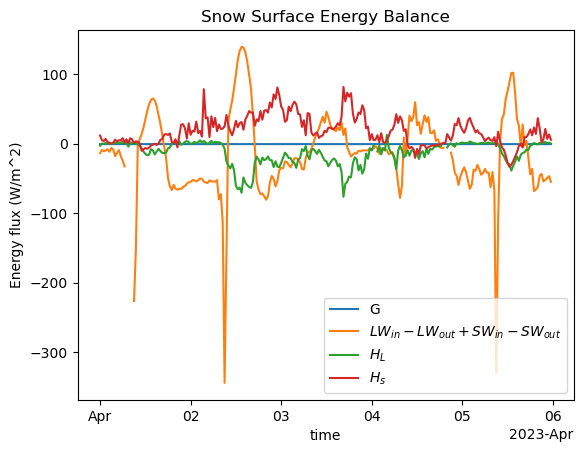

In [29]:
time_slice = slice('20230401', '20230405')
ground_heat_flux.sel(time=time_slice).plot(label=r'G')
net_radiation.sel(time=time_slice).plot(label=r'$LW_{in} - LW_{out} + SW_{in} - SW_{out}$')
latent_heat_flux.sel(time=time_slice).plot(label=r'$H_L$')
sensible_heat_flux.sel(time=time_slice).plot(label=r'$H_s$')
plt.legend()
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

## Calculate the average hourly daily energy balance from the entire dataset (i.e. take the average values for each term, for 1am-2am from all days).

I find this is easier to do with a Pandas Dataframe than an Xarray dataset, so I create a Pandas Dataframe with our results first.

In [32]:
# Create the dataframe with the terms we calculated. Assign the dataframe index as the timestamps.
energy_balance_df = pd.DataFrame({
        'net_radiation': net_radiation,
        'latent_heat_flux': latent_heat_flux,
        'sensible_heat_flux': sensible_heat_flux,
        'ground_heat_flux': ground_heat_flux,
},
    index = net_radiation.time
)
energy_balance_df.head()

,net_radiation,latent_heat_flux,sensible_heat_flux,ground_heat_flux
2022-11-01 00:00:00,-68.235901,0.462150,1.798522,-31.686270
2022-11-01 00:30:00,-67.883957,0.263518,8.952477,-35.483719
2022-11-01 01:00:00,-67.512054,1.797184,0.394793,-38.152439
2022-11-01 01:30:00,-66.782730,1.439764,7.073821,-40.069736
2022-11-01 02:00:00,-66.476273,3.634344,-8.566571,-41.518188


In [33]:
# Create a column representing the hour of the day
energy_balance_df['hour_of_day'] = energy_balance_df.index.hour

# Groupby the hour_of_day and take the median (instead of the mean, this will handle any outliers, which appear in the radiation data)
energy_balance_df_diurnal_average = energy_balance_df.groupby('hour_of_day').median()

In [34]:
energy_balance_df_diurnal_average

,net_radiation,latent_heat_flux,sensible_heat_flux,ground_heat_flux
hour_of_day,,,,
0,-47.033958,0.066211,4.794281,-2.172254
1,-42.851898,0.177739,4.826415,-2.172254
2,-40.615479,0.056037,4.340652,-2.176105
3,-38.523750,0.187343,3.317965,-2.179646
4,-40.751106,0.193451,3.180370,-2.216712
5,-39.858032,0.356504,3.584616,-2.216346
6,-34.822273,0.051772,2.867932,-2.216344
7,-19.617561,-0.768515,1.418502,-2.215849
8,-0.127869,-3.778184,0.651874,-2.039605


Text(0, 0.5, 'Energy flux (W/m^2)')

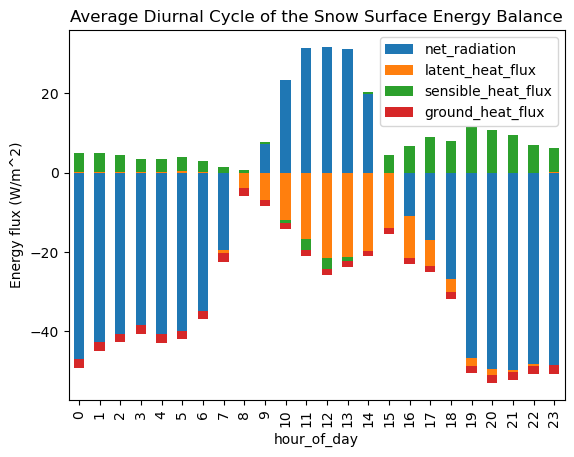

In [35]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Average Diurnal Cycle of the Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

# Estimating the change in internal energy (i.e. estimating the residual)
According to our simplified energy balance equation, 

$$c_p^{S} \int^D_0 \frac{\partial T_{s}}{\partial t} dz = R_{net} - H_L - H_s + G$$

we can estimate the left side (the change in internal energy) by combining the terms on the right, for which we have measurements.

Let's do that!

In [36]:
energy_balance_df_diurnal_average['internal_energy_change'] = (
    energy_balance_df_diurnal_average['net_radiation'] 
    - energy_balance_df_diurnal_average['latent_heat_flux'] # we already negated latent heat flux above, so we need to un-negate it here
    - energy_balance_df_diurnal_average['sensible_heat_flux'] # we already negated sensible heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['ground_heat_flux']
)

Text(0, 0.5, 'Energy flux (W/m^2)')

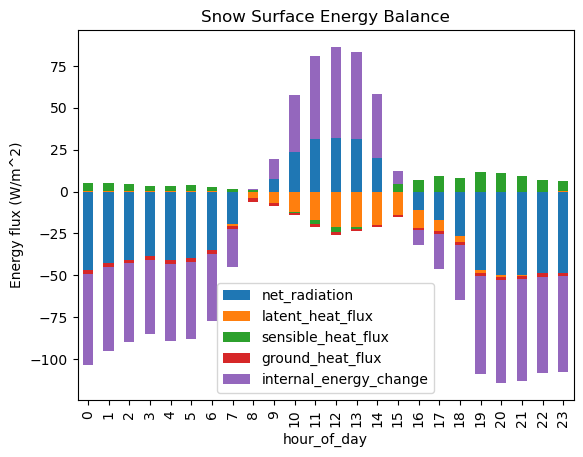

In [37]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

This makes sense! We expect the internal energy (the temperature) of the snowpack to increase at night and decrease during the day!

Can you think of any issues with our method for estimating of internal energy change here?